In [3]:
# Bad subjects
# Bad IDs: 605515760919, 601983541597

print(train[311])
print(train[407])

{'meta': {'AgeInMonths': 108, 'Gender': 'M', 'Ethnicity': 'CAUCASIAN/WHITE', 'AgeGroupID': 1, 'AgeGroupEdge1': 103, 'AgeGroupEdge2': 144}, 'rest': '627', 'nback': '644', 'emoid': '407', 'ID': 607211409849}
{'meta': {'AgeInMonths': 186, 'Gender': 'M', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 3, 'AgeGroupEdge1': 180, 'AgeGroupEdge2': 216}, 'rest': '582', 'nback': '597', 'emoid': '359', 'ID': 606705667955}


In [374]:
# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split3.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))
print(train[0])

467
155
{'meta': {'AgeInMonths': 110, 'Gender': 'M', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 1, 'AgeGroupEdge1': 103, 'AgeGroupEdge2': 144}, 'rest': '765', 'nback': '790', 'emoid': '554', 'ID': 608665596582}


In [375]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['rest']), '../../rest_fmri_power264/timeseries') for subj in train]
train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['rest']), '../../rest_fmri_power264/timeseries') for subj in test]
test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [376]:
# Normalize data

import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
#         if np.sum(np.isnan(subj)) > 0:
#             print(i)
#         if np.sum(np.isinf(subj)) > 0:
#             print(i)

normalizeSubjects(train_rest_ts)
normalizeSubjects(train_nback_ts)
normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
normalizeSubjects(test_nback_ts)
normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [377]:
# Create labels (ages)

y_train = np.vstack([subj['meta']['AgeInMonths'] for subj in train])
y_test = np.vstack([subj['meta']['AgeInMonths'] for subj in test])

print('Complete')

Complete


In [378]:
# Torch

import torch
import torch.nn as nn
import torch.nn.functional as F

import random

train_rest_torch = [torch.from_numpy(subj.T).float() for subj in train_rest_ts]
train_nback_torch = [torch.from_numpy(subj.T).float() for subj in train_nback_ts]
train_emoid_torch = [torch.from_numpy(subj.T).float() for subj in train_emoid_ts]

test_rest_torch = [torch.from_numpy(subj.T).float() for subj in test_rest_ts]
test_nback_torch = [torch.from_numpy(subj.T).float() for subj in test_nback_ts]
test_emoid_torch = [torch.from_numpy(subj.T).float() for subj in test_emoid_ts]

print('Torch complete')

Torch complete


In [379]:
def getKLDiv(mu, logvar):
    return -0.5*torch.sum(1 + logvar - mu**2 - logvar.exp())

def corrcoef(x1):
    x1c = x1 - torch.mean(x1, 0, keepdim=True)
    x1n = x1c/torch.sqrt(torch.sum(x1c*x1c, 0, keepdim=True))
    return x1n.T@x1n

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc11 = nn.Linear(264,132)
        self.fc12 = nn.Linear(132,120)
        self.fc13 = nn.Linear(60,132)
        self.fc14 = nn.Linear(132,264)
        
        self.fc21 = nn.Linear(264,132)
        self.fc22 = nn.Linear(132,120)
        self.fc23 = nn.Linear(60,132)
        self.fc24 = nn.Linear(132,264)
        
        self.fc31 = nn.Linear(264,132)
        self.fc32 = nn.Linear(132,120)
        self.fc33 = nn.Linear(60,132)
        self.fc34 = nn.Linear(132,264)
        
    def getMuLogVar(self, x, modality):
        xsav = x
        if modality == 'rest':
            fc1 = self.fc11
            fc2 = self.fc12
        elif modality == 'nback':
            fc1 = self.fc21
            fc2 = self.fc22
        elif modality == 'emoid':
            fc1 = self.fc31
            fc2 = self.fc32
        x = F.relu(fc1(x))
        x = fc2(x)
        mu = x[:,:60]
        logvar = x[:,60:]
        return mu, logvar
    
    def encode(self, x, modality):
        mu, logvar = self.getMuLogVar(x, modality)
        KLDiv = getKLDiv(mu, logvar)
        eps = torch.randn(60)
        x = mu + torch.sqrt(logvar.exp())*eps
        return x, KLDiv
    
    def decode(self, x, modality):
        if modality == 'rest':
            fc3 = self.fc13
            fc4 = self.fc14
        elif modality == 'nback':
            fc3 = self.fc23
            fc4 = self.fc24
        elif modality == 'emoid':
            fc3 = self.fc33
            fc4 = self.fc34
        x = F.relu(fc3(x))
        x = fc4(x)
        return x

    def forward(self, x):
        x1, KLDiv1, x1cor = None, None, None
        x2, KLDiv2, x2cor = None, None, None
        x3, KLDiv3, x3cor = None, None, None
        if x[0] is not None:
            x1, KLDiv1 = self.encode(x[0], 'rest') 
            x1cor = corrcoef(x1)
            x1 = self.decode(x1, 'rest')
        if x[1] is not None:
            x2, KLDiv2 = self.encode(x[1], 'nback') 
            x2cor = corrcoef(x2) 
            x2 = self.decode(x2, 'nback') 
        if x[2] is not None:
            x3, KLDiv3 = self.encode(x[2], 'emoid')
            x3cor = corrcoef(x3)
            x3 = self.decode(x3, 'emoid')
        return x1, x2, x3, KLDiv1, KLDiv2, KLDiv3, x1cor, x2cor, x3cor

In [380]:
vae = VAE()
optim = torch.optim.SGD(vae.parameters(), momentum=0.5, weight_decay=5, lr=5e-6)

In [381]:
N = len(train_rest_torch)-1
running = 0
running1 = 0
running2 = 0
running3 = 0

vaeTraining = []
reconTraining = []
DCLTraining = []
KLDivTraining = []
epochs = []

for epoch in range(10000):
    # Choose subject
    idx = random.randint(0,N)
    subj1 = train_rest_torch[idx]
    subj2 = train_nback_torch[idx]
    subj3 = train_emoid_torch[idx]
    
    # Train
    optim.zero_grad()
    recon1, recon2, recon3, KLDiv1, KLDiv2, KLDiv3, x1cor, x2cor, x3cor = vae([subj1, subj2, subj3])
    lossRecon = torch.sum((subj1-recon1)**2) + torch.sum((subj2-recon2)**2) + torch.sum((subj3-recon3)**2)
    lossDCL = 0 #0.2*torch.sum((x1cor - x2cor)**2) + 0.2*torch.sum((x2cor - x3cor)**2) + 0.2*torch.sum((x1cor - x3cor)**2)
    lossKLDiv = 0 #KLDiv1 + KLDiv2 + KLDiv3
    loss = lossRecon + lossDCL + lossKLDiv
    loss.backward()
    #loss.backward(retain_graph=True)
    
    # Backpropagate
    optim.step()
    
    running += loss
    running1 += lossRecon
    running2 += lossDCL
    running3 += lossKLDiv

    # print statistics
    if epoch % 400 == 0:    
        if epoch != 0:
            val = running/400
            val1 = running1/400
            val2 = running2/400
            val3 = running3/400
        else:
            val = running
            val1 = running1
            val2 = running2
            val3 = running3
        vaeTraining.append(val)
        reconTraining.append(val1)
        DCLTraining.append(val2)
        KLDivTraining.append(val3)
        epochs.append(epoch)
        print('[epoch {:d}] loss: {:.3f}'.format(epoch, val))
        running = 0
        running1 = 0
        running2 = 0
        running3 = 0

print('Finished Training')

[epoch 0] loss: 156934.000
[epoch 400] loss: 106843.203
[epoch 800] loss: 86758.648
[epoch 1200] loss: 77170.492
[epoch 1600] loss: 72242.516
[epoch 2000] loss: 69457.742
[epoch 2400] loss: 65831.203
[epoch 2800] loss: 63408.230
[epoch 3200] loss: 62048.953
[epoch 3600] loss: 59527.574
[epoch 4000] loss: 59571.750
[epoch 4400] loss: 57286.000
[epoch 4800] loss: 56997.289
[epoch 5200] loss: 55759.828
[epoch 5600] loss: 55328.031
[epoch 6000] loss: 54235.191
[epoch 6400] loss: 52704.074
[epoch 6800] loss: 52812.922
[epoch 7200] loss: 51564.922
[epoch 7600] loss: 51224.512
[epoch 8000] loss: 51147.535
[epoch 8400] loss: 51380.086
[epoch 8800] loss: 49973.555
[epoch 9200] loss: 50845.828
[epoch 9600] loss: 48941.520
Finished Training


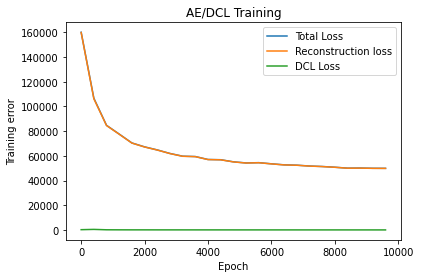

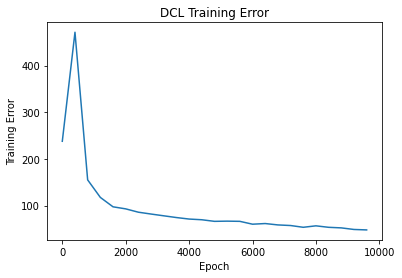

In [373]:
plt.plot(epochs, vaeTraining, label='Total Loss')
plt.plot(epochs, reconTraining, label='Reconstruction loss')
plt.plot(epochs, DCLTraining, label='DCL Loss')
#plt.plot(epochs, KLDivTraining, label='KL Diverge Loss')
plt.title('AE/DCL Training')
plt.ylabel('Training error')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(epochs, DCLTraining)
plt.title('DCL Training Error')
plt.ylabel('Training Error')
plt.xlabel('Epoch')
plt.show()

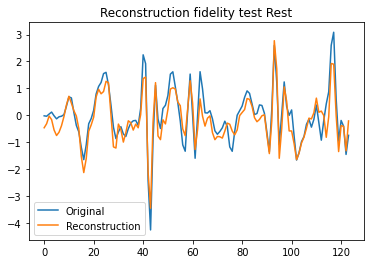

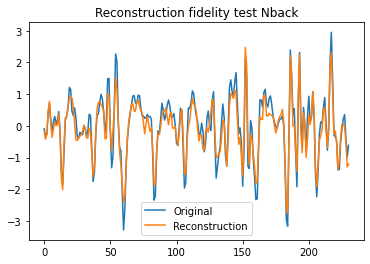

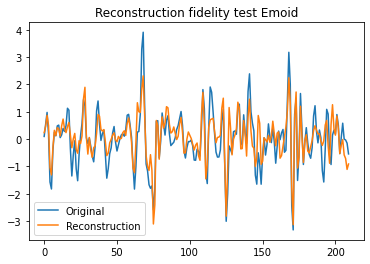

In [382]:
# Check reconstruction

import matplotlib.pyplot as plt

subj1 = test_rest_torch[0]
subj2 = test_nback_torch[0] # train_nback_torch[0]
subj3 = test_emoid_torch[0] # train_emoid_torch[0]

recon1, recon2, recon3, KLDiv1, KLDiv2, KLDiv3, x1cor, x2cor, x3cor = vae([subj1, subj2, subj3])

plt.plot(subj1.detach().numpy()[:,0], label='Original')
plt.plot(recon1.detach().numpy()[:,0], label='Reconstruction')
plt.title('Reconstruction fidelity test Rest')
plt.legend()
plt.show()

plt.plot(subj2.detach().numpy()[:,0], label='Original')
plt.plot(recon2.detach().numpy()[:,0], label='Reconstruction')
plt.title('Reconstruction fidelity test Nback')
plt.legend()
plt.show()

plt.plot(subj3.detach().numpy()[:,0], label='Original')
plt.plot(recon3.detach().numpy()[:,0], label='Reconstruction')
plt.title('Reconstruction fidelity test Emoid')
plt.legend()
plt.show()

In [383]:
# Set up feature vectors

X_train_cor = np.zeros([len(train_rest_torch), 60*60])
X_test_cor = np.zeros([len(test_rest_torch), 60*60])

for i in range(len(train_rest_torch)):
    subj1 = train_rest_torch[i]
    subj2 = train_nback_torch[i]
    subj3 = train_emoid_torch[i]
    
    recon1, recon2, recon3, KLDiv1, KLDiv2, KLDiv3, x1cor, x2cor, x3cor = vae([subj1, subj2, subj3])
    #X_train_cor[i,:] = np.hstack([x1cor.detach().numpy().flatten(), x2cor.detach().numpy().flatten()])
    X_train_cor[i,:] = x3cor.detach().numpy().flatten()
    
for i in range(len(test_rest_torch)):
    subj1 = test_rest_torch[i]
    subj2 = test_nback_torch[i]
    subj3 = test_emoid_torch[i]
    
    recon1, recon2, recon3, KLDiv1, KLDiv2, KLDiv3, x1cor, x2cor, x3cor = vae([subj1, subj2, subj3])
    #X_train_cor[i,:] = np.hstack([x1cor.detach().numpy().flatten(), x2cor.detach().numpy().flatten()])
    X_test_cor[i,:] = x3cor.detach().numpy().flatten()
    
print('Complete')

Complete


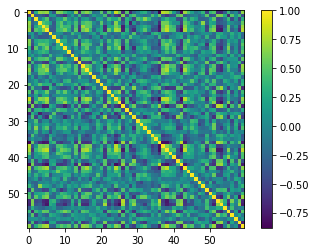

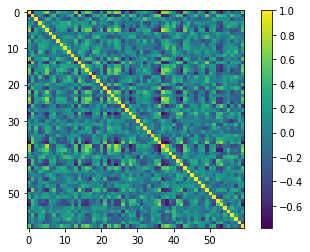

In [384]:
# Check correlation matrices from AE

plt.imshow(X_train_cor[1,:].reshape([60,60]))
plt.colorbar()
plt.show()

plt.imshow(X_test_cor[4,:].reshape([60,60]))
plt.colorbar()
plt.show()

In [359]:
# Linear regression

w1 = np.linalg.lstsq(X_train_cor, y_train, rcond=None)[0]

print('Complete')

Complete


In [360]:
y1 = X_train_cor@w1
mseTrain = (1/len(y_train))*np.sum((y_train - y1)**2)

y2 = X_test_cor@w1
mseTest = (1/len(y_test))*np.sum((y_test - y2)**2)

print('Training error:  {:.2f} years'.format(np.sqrt(mseTrain)/12))
print('Test error: {:.2f} years'.format(np.sqrt(mseTest)/12))

Training error:  0.00 years
Test error: 3.52 years


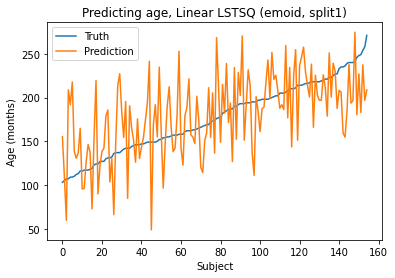

In [361]:
import matplotlib.pyplot as plt

idcs = np.argsort(y_test.flatten())

plt.plot(y_test[idcs], label='Truth')
plt.plot(y2[idcs], label='Prediction')
plt.title('Predicting age, Linear LSTSQ (emoid, split1)')
plt.legend()
plt.xlabel('Subject')
plt.ylabel('Age (months)')
plt.show()

In [362]:
# Polynomial regression
# Third degree polynomial

def makePolynomial(X, degree):
    d = X.shape[1]
    Xpoly = np.zeros([X.shape[0], d*degree])
    for i in range(degree):
        Xpoly[:,i*d:(i+1)*d] = X**(i+1)
    return Xpoly

Xpoly_train = makePolynomial(X_train_cor, 3)
Xpoly_test = makePolynomial(X_test_cor, 3)

print('Complete')

w2 = np.linalg.lstsq(Xpoly_train, y_train, rcond=None)[0]

print('Complete')

Complete
Complete


In [363]:
y3 = Xpoly_train@w2
mseTrain = (1/len(y_train))*np.sum((y_train - y3)**2)

y4 = Xpoly_test@w2
mseTest = (1/len(y_test))*np.sum((y_test - y4)**2)

print('Training error:  {:.2f} years'.format(np.sqrt(mseTrain)/12))
print('Test error: {:.2f} years'.format(np.sqrt(mseTest)/12))

Training error:  0.00 years
Test error: 3.11 years


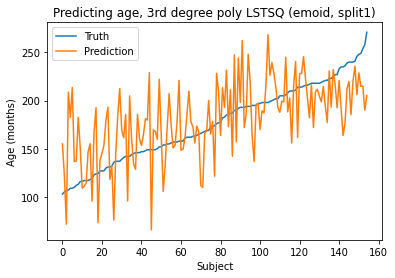

In [364]:
idcs = np.argsort(y_test.flatten())

plt.plot(y_test[idcs], label='Truth')
plt.plot(y4[idcs], label='Prediction')
plt.title('Predicting age, 3rd degree poly LSTSQ (emoid, split1)')
plt.legend()
plt.xlabel('Subject')
plt.ylabel('Age (months)')
plt.show()

In [18]:
# MLP

import torch
import torch.nn as nn
import torch.nn.functional as F

import random

class MLPSingle(nn.Module):
    def __init__(self):
        super(MLPSingle, self).__init__()
        self.fc1 = nn.Linear(60*60,30)
        self.fc2 = nn.Linear(30,1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [365]:
mlpSingle = MLPSingle()
optimSingle = torch.optim.SGD(mlpSingle.parameters(), momentum=0.5, lr=2e-6)
print('Single complete')

Single complete


In [366]:
N = X_train_cor.shape[0]-1
running = 0

mlpTraining = []
epochs = []

for epoch in range(120000):
    # Choose subject
    idx = random.randint(0,N)
    subj = torch.from_numpy(X_train_cor[idx,:]).float()
    truth = y_train[idx,0]
    
    # Train
    optimSingle.zero_grad()
    age = mlpSingle(subj)
    loss = (truth-age)**2
    loss.backward()
    
    # Backpropagate
    optimSingle.step()
    
    running += loss

    # print statistics
    if epoch % 1000 == 0:    
        if epoch != 0:
            val = ((running[0]/1000)**0.5)/12
        else:
            val = (running[0]**0.5)/12
        mlpTraining.append(val)
        epochs.append(epoch)
        print('[epoch {:d}] loss: {:f}'.format(epoch, val))
        running = 0

print('Finished Training')

[epoch 0] loss: 16.593519
[epoch 1000] loss: 6.368642
[epoch 2000] loss: 2.961026
[epoch 3000] loss: 2.849669
[epoch 4000] loss: 2.701571
[epoch 5000] loss: 2.565756
[epoch 6000] loss: 2.632107
[epoch 7000] loss: 2.509699
[epoch 8000] loss: 2.355398
[epoch 9000] loss: 2.289659
[epoch 10000] loss: 2.291233
[epoch 11000] loss: 2.260979
[epoch 12000] loss: 2.171547
[epoch 13000] loss: 2.156173
[epoch 14000] loss: 2.122528
[epoch 15000] loss: 2.120666
[epoch 16000] loss: 1.932375
[epoch 17000] loss: 1.993047
[epoch 18000] loss: 1.953580
[epoch 19000] loss: 1.934795
[epoch 20000] loss: 1.891029
[epoch 21000] loss: 1.920842
[epoch 22000] loss: 1.803765
[epoch 23000] loss: 1.838819
[epoch 24000] loss: 1.799015
[epoch 25000] loss: 1.722953
[epoch 26000] loss: 1.794555
[epoch 27000] loss: 1.679815
[epoch 28000] loss: 1.702583
[epoch 29000] loss: 1.674905
[epoch 30000] loss: 1.682178
[epoch 31000] loss: 1.650158
[epoch 32000] loss: 1.609346
[epoch 33000] loss: 1.573892
[epoch 34000] loss: 1.6325

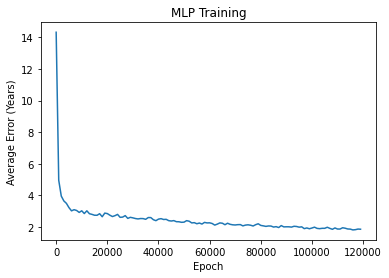

In [309]:
plt.plot(epochs, mlpTraining)
plt.title('MLP Training')
plt.ylabel('Average Error (Years)')
plt.xlabel('Epoch')
plt.show()

In [367]:
def getResults(mlp, X_subjects):
    y = np.zeros([X_subjects.shape[0],1])
    for i in range(X_subjects.shape[0]):
        subj = torch.from_numpy(X_subjects[i,:]).float()
        age = mlp(subj)
        y[i] = int(age)
    return y

y5 = getResults(mlpSingle, X_train_cor)
y6 = getResults(mlpSingle, X_test_cor)

mseTrain = (1/len(y_train))*np.sum((y_train - y5)**2)
mseTest = (1/len(y_test))*np.sum((y_test - y6)**2)

print('Training error:  {:.2f} years'.format(np.sqrt(mseTrain)/12))
print('Test error: {:.2f} years'.format(np.sqrt(mseTest)/12))

Training error:  0.72 years
Test error: 3.08 years


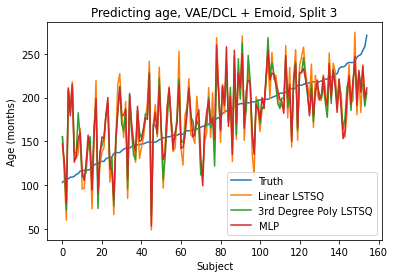

In [368]:
idcs = np.argsort(y_test.flatten())

plt.plot(y_test[idcs], label='Truth')
plt.plot(y2[idcs], label='Linear LSTSQ')
plt.plot(y4[idcs], label='3rd Degree Poly LSTSQ')
plt.plot(y6[idcs], label='MLP')
plt.title('Predicting age, VAE/DCL + Emoid, Split 3')
plt.legend()
plt.xlabel('Subject')
plt.ylabel('Age (months)')
plt.show()